In [117]:
#!pip install optuna
import pandas as pd
import pickle
import datetime
import re
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
import matplotlib.pyplot as pit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive

# exports
def plot_calibration_curve(named_classifiers, X_test, y_test):
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="完全な補正")
    for name, clf in named_classifiers.items():
        prob_pos = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, prob_pos)
        brier = brier_score_loss(y_test, prob_pos)
        print("%s:" % name)
        print("\tAUC  : %1.3f" % auc)
        print("\tBrier: %1.3f" % (brier))
        print()

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test,
            prob_pos,
            n_bins=10,
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label="%s (%1.3f)" % (name, brier),
        )

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

    ax1.set_ylabel("正例の比率")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title("信頼性曲線")

    ax2.set_xlabel("予測値の平均")
    ax2.set_ylabel("サンプル数")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

def preprocessing(results, kako=5):
    df = results.copy()
    # df['rank'] = df['result'].map(lambda x: 1 if x < 4 else 0)
    df['rank'] = df['result'].map(lambda x: 1 if x == 1 else 0)
#     df = df[-(df['前走レースID(新)'].astype(str).str.contains("\D"))]
    
#     df['斤量'] = df['斤量'].map(lambda x: re.sub('▲|☆|△|◇|★', '', str(x)))
#     df['斤量'] = df['斤量'].astype(float)
#     df = df[-(df['着順'].astype(str).str.contains("\D"))]
#     df['着順'] = df[df['着順'].notna()]['着順'].astype(int).map(lambda x: x if x < 4 else 4)
    # df['rank'] = df['result'].map(lambda x: 1 if x < 4 else 0)
    df['rank'] = df['result'].map(lambda x: 1 if x == 1 else 0)
#     df['着差']  = df[-(df['着差'] == '----')]['着差'].astype(float)
#     df['time'] = df['走破タイム'].map(lambda x: ((int(x[0])*60*10) + (((int(x[2]) *10) + int(x[3]))* 10) + int(x[5])))
#     df['difference'] = [-(df['着差'] == '----')]['着差'].astype(np.float64)
#     df['馬体重増減'] = df['馬体重増減'].astype(float)
    
#     race_place = {"札幌" : 1,"函館" : 2,"福島" : 3,"新潟" : 4,"東京" : 5,"中山" : 6,"中京" : 7,"京都" : 8,"阪神" : 9,"小倉" : 10}
#     df['場所'] = df['場所'].map(lambda x: race_place[x])

#     course = { "芝": 1, "ダ": 2 }
#     df['コース'] = df['距離'].map(lambda x: course[x[:1]])
#     df['コース'] = df['距離'].map(lambda x: x[:1])
#     df['距離'] = df['距離'].map(lambda x: re.split('芝|ダ', x)[1]).astype(int)
#     df['date'] = df['レースID(新)'].astype(str).map(lambda x: datetime.datetime.strptime(x[:8], '%Y%m%d'))
    
#     df['単勝支持率'] = 0.8 / df['単勝オッズ']
    df.drop([
        'popular', 'compi', 'compi_num', 
#         "jockey_id",
        "speed", "id",
        'result',
        'start_time',
        'name'
    ], axis=1, inplace=True)
    df['date'] = df['date'].astype(str).map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    
#     df.drop(['レースID(新)', '前走レースID(新)','クラス名', '出走頭数', '馬体重', '馬名', '着順',
# #              '単勝オッズ',
#              '人気', 
# #              'スピード指数',
#              'コンピ指数', 'コンピ順位',
# #              'コンピ一位指数',
#                    '多頭出し', '所属', '騎手', '調教師','種牡馬', '母父馬','馬連', '３連単', '走破タイム', '着差', 
#                    '1角', '2角', '3角', '4角',
#              '上り3F', '上り3F順', '賞金', '付加賞金'], axis=1, inplace=True)

#     for i in range(15, 62):
#         df.drop(['peds' + str(i)], axis=1, inplace=True)
#         str_num = str(i) + '走前'
#         df[str_num + '着差']  = df[-(df[str_num + '着差'] == '----')][str_num + '着差'].astype(float)
#         df[str_num + '着順'] = df[df[str_num + '着順'].notna()][str_num + '着順']
#         df[str_num + '着順'] = df[-(df[str_num + '着順'] == 0.0)][str_num + '着順']
#         df[str_num + '着順'] = df[-(df[str_num + '着順'] == 0.5)][str_num + '着順']
# #         df[str_num + '_rank'] = df[df[str_num + '着順'].notna()][str_num + '着順'].astype(int).map(lambda x: x if x < 4 else 4)
#         df[str_num + '斤量'] = df[str_num + '斤量'].map(lambda x: re.sub('▲|☆|△|◇|★', '', str(x)))
#         df[str_num + '斤量'] = df[str_num + '斤量'].astype(float)
#         df[str_num + '場所'] = df[df[str_num + '場所'].notna()][str_num + '場所'].map(lambda x: race_place[x])
#         df[str_num + 'コース'] = df[df[str_num + 'コース'].notna()][str_num + 'コース'].map(lambda x: course[x])

#     df = df.set_index('レースID(新/馬番無)')
    
#     standard_scaler = lambda  x: (x - x.mean()) / x.std()
#     for i in range(1, 10):
#         df[str(i) + '走前タイム'] = df.groupby(level=0)[str(i) + '走前タイム'].transform(standard_scaler)
#         df[str(i) + '走前タイム'] = (df[str(i) + '走前タイム']- df[str(i) + '走前タイム'].min()) / (df[str(i) + '走前タイム'].max() - df[str(i) + '走前タイム'].min())

    df = df.sort_values(by='date', ascending = False)
    df = df.set_index('race_id')
    return df

def split_data(df, test_size=0.3, place=None):
    sorted_ids = df.sort_values('date').index.unique()
    train_ids = sorted_ids[:round(len(sorted_ids) * (1-test_size))]
    test_ids = sorted_ids[round(len(sorted_ids) * (1-test_size)):]
#     df = df.copy()
#     df = df[df['date'] < '2022-01-01']
#     if (place == 'local'):
#          df = df[-((df['場所'] == 5) | (df['場所'] == 6) | (df['場所'] == 9))]
#     if (place == 'center'):
#         df = df[(df['場所'] == 5) | (df['場所'] == 6) | (df['場所'] == 9)]
#     train_ids = df[df['date'] < '2021-01-01'].index.unique()
#     test_ids = df[df['date'] > '2021-01-01'].index.unique()
    
    train = df.loc[train_ids]
    test = df.loc[test_ids]
    
    return train, test

def train_valid_split_data(df, test_size=0.3):
    sorted_ids = df.sort_values('date').index.unique()
    train_ids = sorted_ids[:round(len(sorted_ids) * (1-test_size))]
    test_ids = sorted_ids[round(len(sorted_ids) * (1-test_size)):]
    
    train = df.loc[train_ids]
    valid = df.loc[test_ids]
    
    return train, valid

def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))
    # df2 = pd.get_dummies(df2, sparse=True)
    df2 = pd.get_dummies(df2)
    for column in target_columns:
        df2[column] = df2[column].astype('category')
        
    return df2

class ModelEvaluator:
    def __init__(self, model, haitou_table, std = True):
        self.model = model
        self.haitou = haitou_table
        self.std = std
        self.pp = None
        
    def predict_proba(self, X, std=True):
#         proba = pd.Series(self.model.predict_proba(X)[:, 1], index=X.index)
        if self.pp is not None:
          return self.pp

        proba = pd.Series(self.model.predict_proba(X.drop(['odds'], axis=1))[:, 1], index=X.index)
        if std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            proba = (proba - proba.min()) / (proba.max() - proba.min())
            
        self.pp = proba
        return proba
    
    def prefict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        proba = self.predict_proba(X_test, True)
        n = lambda x: 0.0 if np.isnan(x) else x
        proba = proba.map(n)
        return roc_auc_score(y_true, proba)
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({'features': X.columns, 'importance': self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        # pred_table = X.copy()[['h_num', 'odds', 'proba']]
        pred_table = X.copy()[['h_num', 'odds']]
        pred_table['pred'] = self.prefict(X, threshold)
        if bet_only:
            pred_table = pred_table.query('pred == 1 & odds > 4')[['h_num', 'odds']]
#             pred_table = pred_table.query('pred == 1 & odds >= 5')[['h_num', 'odds']]
            return pred_table
        else:
            return pred_table
        
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        haitou = self.haitou.copy()
        df = haitou.merge(pred_table, left_index=True, right_index=True, how='right')

        n_hits = len(df[df['1着馬番'] == df['h_num']]) + len(df[df['2着馬番'] == df['h_num']]) + len(df[df['3着馬番'] == df['h_num']]) + len(df[df['4着馬番'] == df['h_num']])
        for i in range(1, 5):
            money += df[df[str(i) + '着馬番'] == df['h_num']]['複勝' + str(i)].sum()
        return_rate =  (n_bets*100 + money) / (n_bets * 100)
        return n_bets, return_rate,n_hits
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        
        n_races = pred_table.index.nunique()
        
        money = -100 * n_bets
        df = self.haitou.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        df['単勝配当'] = df['単勝'].astype(int)
        
        std = ((df['1着馬番'] ==  df['h_num']) * df['単勝配当'])\
        .groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
        
        n_hits = len(df[df['1着馬番'] == df['h_num']])
        
        money += df[df['1着馬番'] == df['h_num']]['単勝配当'].sum()
        return_rate =  (n_bets*100 + money) / (n_bets * 100)
        return n_bets, return_rate, n_hits
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        df = self.haitou.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        bet_money = (1/pred_table['odds']).sum()
        std = ((df['1着馬番'] == df['h_num']).astype(int)).groupby(level=0).sum().std() * np.sqrt(n_races) / bet_money
        
        df['h_num'] = df['h_num'].astype(float)
        df['馬番_1'] = df['1着馬番']
        n_hits = len(df.query('馬番_1 == h_num'))
        return_rate = n_hits/bet_money
        return n_bets, return_rate, n_hits
    
def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = 1 * i /n_samples + min_threshold * (1 - i/n_samples)
        n_bets, return_rate, n_hits = return_func(X, threshold)
        if n_bets == 0:
            break;
        if n_bets > lower:
            gain[n_bets] = { 'return_rate': return_rate, 'n_hits': n_hits }
    return pd.DataFrame(gain).T

In [66]:
race_detail = pd.read_csv('./csv_new2/race_detail.csv')

# race_compi = pd.read_csv('./csv_new2/compi.csv')
# race_compi = race_compi.set_index('race_id')

r = race_detail.drop([
                      '1着馬番', '2着馬番', '3着馬番', '4着馬番', '複勝1', '複勝2', '複勝3', '複勝4', '単勝', 
                      '馬連', 
                      # '馬単', 
                      '3連複', '3連単'], axis=1)

In [67]:
# h = haito.merge(new_df, on='race_id')
r['result'] = r['馬単'].map(lambda x: 0 if x > 1000 else 1)
# r['result'] = r[r['馬連'] >= 1000]['馬連'].map(lambda x: 1 if x < 4000 else 2)
# r['result'] = r['result'].map(lambda x: x if x > 0 else 0)
# r['result'] = r['result'].astype(int)
r = r.set_index('race_id')

In [68]:
# details = r.merge(race_compi, on="race_id")
details = r.query('course == 2')

In [69]:
train, test = split_data(details)
# train, valid = train_valid_split_data(train)
X_train = train.drop(['date', 'result', 'course', '馬単'], axis=1)
# X_train = train.drop(['date', 'result'], axis=1)
y_train = train['result']
# X_valid = valid.drop(['date', 'result', '馬単'], axis=1)
# y_valid = valid['result']
X_test = test.drop(['date', 'result', 'course','馬単'], axis=1)
y_test = test['result']

In [70]:
import lightgbm as lgb

params = {
    'bagging_fraction': 0.9242560589066289,
    'bagging_freq': 2,
    'feature_fraction': 0.45199999999999996,
    'feature_pre_filter': False,
    'lambda_l1': 0.7185231451120976,
    'lambda_l2': 1.0705431794405939e-08,
    'min_child_samples': 25,
    'num_leaves': 8,
    'objective': 'binary',
    'random_state': 100
 }

lgb_clf1 = lgb.LGBMClassifier(**params)
lgb_clf1.fit(X_train.values, y_train.values)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.45199999999999996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45199999999999996
[LightGBM] [Warning] bagging_fraction is set=0.9242560589066289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9242560589066289
[LightGBM] [Warning] lambda_l2 is set=1.0705431794405939e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0705431794405939e-08
[LightGBM] [Warning] lambda_l1 is set=0.7185231451120976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7185231451120976


LGBMClassifier(bagging_fraction=0.9242560589066289, bagging_freq=2,
               feature_fraction=0.45199999999999996, feature_pre_filter=False,
               lambda_l1=0.7185231451120976, lambda_l2=1.0705431794405939e-08,
               min_child_samples=25, num_leaves=8, objective='binary',
               random_state=100)

In [427]:
# import optuna.integration.lightgbm as lgb_o

# lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
# lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

# params = {
#     'objective': 'binary',
#     'random_state': 100
# }

# lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_train, lgb_valid), verbose_eval=100, early_stopping_rounds=10)

In [428]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 9.422860463267318,
 'lambda_l2': 4.833228809452288e-07,
 'num_leaves': 5,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.5129748919162336,
 'bagging_freq': 3,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

LGBM:
	AUC  : 0.674
	Brier: 0.103

CalibratedLGBM:
	AUC  : 0.674
	Brier: 0.103



/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_27642/1248785849.py:58: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_27642/1248785849.py:58: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_27642/1248785849.py:58: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_27642/1248785849.py:58: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_27642/1248785849.py:58: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_2764

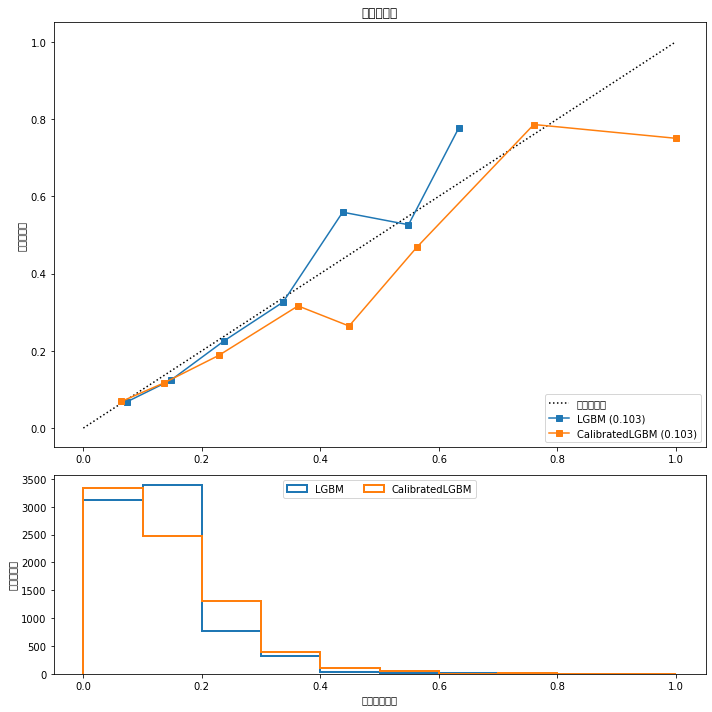

In [71]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
calib = CalibratedClassifierCV(lgb_clf1, cv="prefit", method="isotonic")
calib.fit(X_train.values, y_train.values)
plot_calibration_curve(dict(LGBM=lgb_clf1, CalibratedLGBM=calib), X_test, y_test)

In [72]:
proba = pd.Series(lgb_clf1.predict_proba(X_test)[:, 1], index=X_test.index)
roc_auc_score(y_test, proba)
# proba.max()
# proba = pd.Series(self.model.predict_proba(X.drop(['odds'], axis=1))[:, 1], index=X.index)

0.6739600898721592

In [73]:
importances = pd.DataFrame({'features': X_test.columns, 'importance': lgb_clf1.feature_importances_})
importances.sort_values('importance', ascending=False)[:40]

,features,importance
0,気温,123
1,風速,106
7,頭数,99
8,place_id,80
10,grade,75
9,distance,68
2,風向,67
6,cond,41
5,weather,20
3,直線追い風,11


In [74]:
rd = race_detail[['race_id']]
rd = rd.set_index('race_id')
rd

p = proba.copy()
pdd = pd.DataFrame(p)
rdp = pdd.merge(rd, on="race_id")
rdp['proba'] =  rdp[0]
rdp = rdp.drop([0], axis=1)

In [122]:
allrace = pd.read_pickle('./pickle_new/base_race.pickle')
# a = allrace.query('2 <= grade < 5')
# a = allrace.query('grade == 2 & not place_id == 5 & not place_id == 6 & not place_id == 8 & not place_id == 9')
a = allrace.query('(grade == 1) & course == 2 & not place_id == 5 & not place_id == 6 & not place_id == 8 & not place_id == 9')
all_r = preprocessing(a)
all_r.drop(['horse_id'], axis=1, inplace=True)

In [119]:
# peds = pd.read_csv('/content/drive/MyDrive/DATA/horses.csv')
# peds = peds.head()
# peds.drop(['id'], axis=1, inplace=True)
# categorical_column = ['horse_id', 'producer', 'owner', 'training_course'] + list(peds.columns)
# all_r.drop(['peds1', 'peds2'], axis=1, inplace=True)
for i in range(1, 63):
    all_r.drop(['peds' + str(i)], axis=1, inplace=True)

categorical = process_categorical(all_r, ['producer', 'owner', 'training_course'])

In [77]:
categorical = categorical.merge(rdp, on='race_id')

In [124]:
allrace

,id,date,race_id,result,jockey_id,multiple,affiliation_id,trainer_id,gender,weight,...,種牡馬同コース同距離別複勝率偏差値,気温,風速,風向,直線追い風,直線向かい風,天候,馬場状態,頭数,grade
0,200709080102010101,2007-09-08 00:00:00,2007090801020101,2.0,1025,0,1,106,2,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200709080102010102,2007-09-08 00:00:00,2007090801020101,3.0,945,0,2,1046,1,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200709080102010107,2007-09-08 00:00:00,2007090801020101,10.0,1032,0,2,1021,1,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200709080102010108,2007-09-08 00:00:00,2007090801020101,12.0,1098,0,1,377,2,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200709080102010109,2007-09-08 00:00:00,2007090801020101,9.0,674,0,2,362,2,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,202208060402031211,2022-08-06 16:30:00,2022080604020312,NaN,732,0,2,1185,3,0,...,30.347944,32.0,3.0,7.0,0.0,0.0,1.0,2.0,15.0,4.0
326,202208060402031212,2022-08-06 16:30:00,2022080604020312,NaN,1077,0,1,1119,2,0,...,50.238018,32.0,3.0,7.0,0.0,0.0,1.0,2.0,15.0,4.0
327,202208060402031213,2022-08-06 16:30:00,2022080604020312,NaN,5203,0,2,362,3,0,...,49.909832,32.0,3.0,7.0,0.0,0.0,1.0,2.0,15.0,4.0
328,202208060402031214,2022-08-06 16:30:00,2022080604020312,NaN,1193,0,1,1133,2,0,...,37.995677,32.0,3.0,7.0,0.0,0.0,1.0,2.0,15.0,4.0


In [120]:
train, test = split_data(categorical)
# train, valid = train_valid_split_data(train)

X_train = train.drop(['date', 'rank', 'odds'], axis=1)
# X_train = train.drop(['date', 'rank'], axis=1)
y_train = train['rank']
# X_valid = valid.drop(['date', 'rank', 'odds'], axis=1)
# y_valid = valid['rank']
X_test = test.drop(['date', 'rank'], axis=1)
y_test = test['rank']

KeyError: 'date'

In [94]:
import lightgbm as lgb


# ダート ローカル
params = {'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 4.9029186463098595,
 'lambda_l2': 9.539832165020321,
 'num_leaves': 7,
 'feature_fraction': 0.5,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=9.539832165020321, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.539832165020321
[LightGBM] [Warning] lambda_l1 is set=4.9029186463098595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9029186463098595


LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.5,
               feature_pre_filter=False, lambda_l1=4.9029186463098595,
               lambda_l2=9.539832165020321, num_iterations=1000, num_leaves=7,
               objective='binary', random_state=100)

In [440]:
# import optuna.integration.lightgbm as lgb_o

# lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
# lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

# params = {
#     'objective': 'binary',
#     'random_state': 100
# }

# lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_train, lgb_valid), verbose_eval=100, early_stopping_rounds=10)

In [315]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 3.8200875459362296,
 'lambda_l2': 7.248817254025101e-06,
 'num_leaves': 2,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.5241122219455095,
 'bagging_freq': 6,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

LGBM:
	AUC  : 0.680
	Brier: 0.079

CalibratedLGBM:
	AUC  : 0.598
	Brier: 0.096



/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_27642/1248785849.py:58: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_27642/1248785849.py:58: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_27642/1248785849.py:58: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_27642/1248785849.py:58: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_27642/1248785849.py:58: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_2764

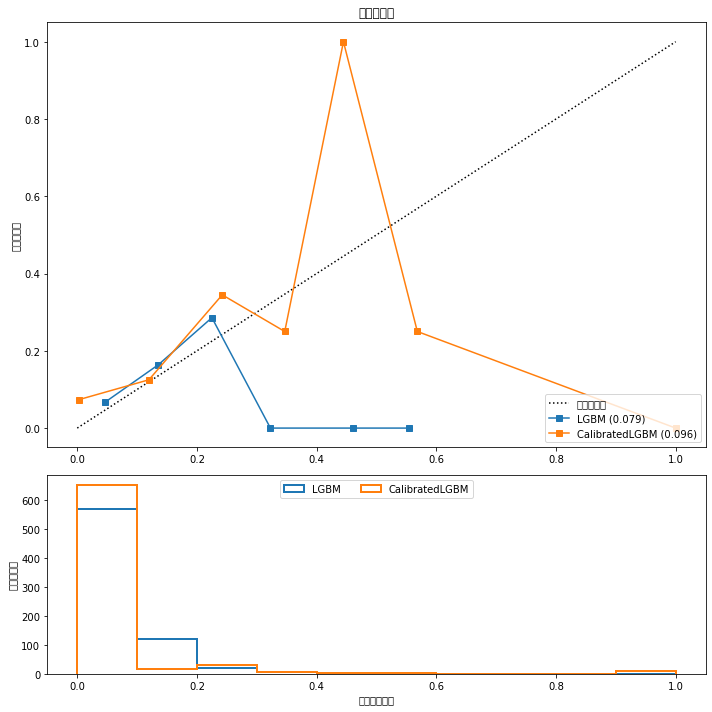

In [95]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

X_test1 = X_test.drop(['odds'], axis=1)

calib = CalibratedClassifierCV(lgb_clf, cv="prefit", method="isotonic")
calib.fit(X_train.values, y_train.values)
plot_calibration_curve(dict(LGBM=lgb_clf, CalibratedLGBM=calib), X_test1, y_test)

In [96]:
haitou = pd.read_csv('./csv_new2/race_detail.csv')
haitou = haitou.set_index('race_id')higashi1

In [97]:
me = ModelEvaluator(lgb_clf, haitou, True)
me1 = ModelEvaluator(calib, haitou, True)

In [98]:
me.score(y_test, X_test)

0.6698565729483282

In [99]:
me1.score(y_test, X_test)

0.5698969414893618

In [100]:
me.feature_importance(X_train, 40)

,features,importance
236,種牡馬競馬場別連対率偏差値,43
197,騎手競馬場別勝率偏差値,40
217,調教師競馬場別連対率偏差値,39
223,調教師距離別騎乗回数偏差値,32
216,調教師競馬場別勝率偏差値,30
7,body_weight,28
226,調教師距離別複勝率偏差値,28
0,jockey_id,28
3,trainer_id,27
225,調教師距離別連対率偏差値,26


In [112]:
step_list = [x * 0.02 for x in range(0, 50)]
return_rate_list = []
for cnt in range(0, len(step_list)):
    step = step_list[cnt]
    n_bets, return_rate, n_hits = me1.tansho_return(X_test, step)
    if n_bets == 0:
        return_rate_list.append(float('nan'))
    elif n_bets > 0:
        return_rate_list.append(return_rate)
return_rate_list

[0.7775,
 0.7873417721518987,
 0.823841059602649,
 0.77578125,
 0.8082228116710876,
 0.9733009708737864,
 0.9828431372549019,
 0.971,
 0.9857868020304569,
 1.006217616580311,
 1.0221052631578946,
 1.0221052631578946,
 0.9761904761904762,
 0.9919354838709677,
 0.9218579234972678,
 0.9218579234972678,
 0.926923076923077,
 0.9320441988950277,
 0.9372222222222222,
 0.9372222222222222,
 0.9372222222222222,
 0.9424581005586592,
 0.9350574712643678,
 0.9350574712643678,
 0.9350574712643678,
 0.9350574712643678,
 0.9350574712643678,
 0.9350574712643678,
 0.9404624277456647,
 0.9404624277456647,
 0.9627218934911242,
 0.9627218934911242,
 0.9627218934911242,
 0.9801204819277108,
 1.016875,
 1.016875,
 0.9424836601307189,
 0.9203947368421053,
 0.9026666666666666,
 0.9026666666666666,
 0.9087248322147651,
 0.9337931034482758,
 0.8979166666666667,
 0.8805755395683453,
 0.8805755395683453,
 0.8733333333333333,
 0.8733333333333333,
 0.8798507462686567,
 0.7,
 0.6378787878787879]

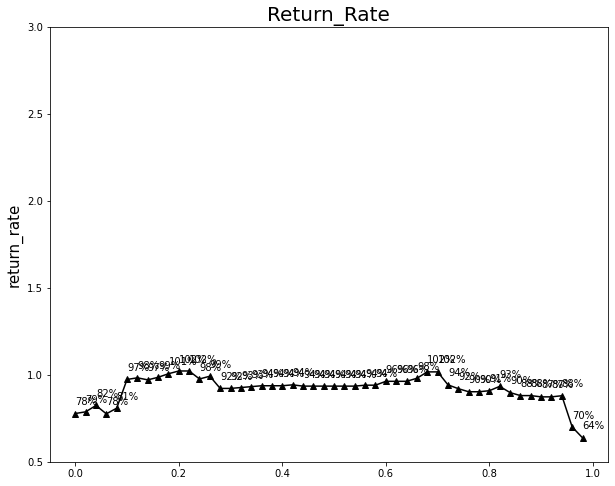

In [113]:
import math

x = step_list
y = return_rate_list
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, linestyle='solid', color='k', marker='^', label='race_cnt')
plt.title('Return_Rate', fontsize=20)

# 軸ラベルを追加
ax.set_ylabel('return_rate', fontsize=15)

# y軸設定
ax.set_ylim(0.5, 3)

# 値ラベルを追加
for i, k in zip(x, y):
    if math.isnan(k):
        continue
    elif k < 0.5 :
        continue
    else:
        plt.text(i, k + 0.05, str(round(k * 100)) + '%', fontsize=10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 72.85it/s]


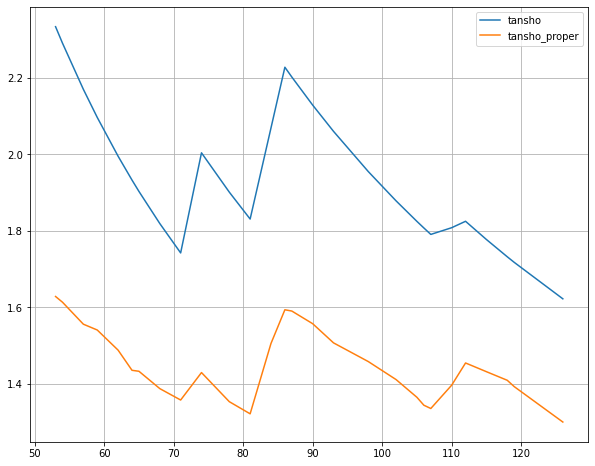

In [115]:
# f = gain(me.fukusho_return, X_test)
tp = gain(me.tansho_return_proper, X_test)
t = gain(me.tansho_return, X_test)

# plt.plot(tp.index, tp['return_rate'], label='proper')
# plt.plot(t.index, t['return_rate'], label='tansho')
# plt.plot(f.index, f['return_rate'], label='fukusho')
plt.figure(figsize=(10, 8))
t['return_rate'].rename('tansho').plot(legend=True)
tp['return_rate'].rename('tansho_proper').plot(legend=True)
# f['return_rate'].rename('fukusho').plot(legend=True)
plt.grid()

In [104]:
X_test.index.nunique()

73

In [105]:
t

,return_rate,n_hits
126,1.622222,17.0
119,1.717647,17.0
118,1.732203,17.0
115,1.777391,17.0
112,1.825000,17.0
110,1.808182,16.0
107,1.790654,15.0
106,1.807547,15.0
105,1.824762,15.0
102,1.878431,15.0


In [106]:
odds = me.pred_table(X_test, threshold=0.6)

In [107]:
df = a.copy()
df.set_index('race_id', inplace=True)
_, sample = split_data(df)

In [108]:
# 賭ける馬
odds

,h_num,odds
race_id,,
2019083104021106,5,5.4
2019110303030205,1,18.0
2019110303030205,3,14.6
2019110303030205,5,7.2
2019121507040605,2,10.4
...,...,...
2022070203020106,11,7.5
2022071603020506,3,10.3
2022071603020506,5,13.1


In [109]:
bets = sample[['result', 'popular', 'h_num']].merge(odds, left_index=True, right_index=True, how='right')
bets

,result,popular,h_num_x,h_num_y,odds
race_id,,,,,
2019083104021106,5,8,1,5,5.4
2019083104021106,2,7,3,5,5.4
2019083104021106,9,2,5,5,5.4
2019083104021106,7,11,6,5,5.4
2019083104021106,1,3,9,5,5.4
...,...,...,...,...,...
2022073004020106,2,9,11,13,5.1
2022073004020106,11,10,12,13,5.1
2022073004020106,4,3,13,13,5.1


In [110]:
b = bets[(bets['h_num_x'] == bets['h_num_y']) & (bets['result'] == 1)]
b

,result,popular,h_num_x,h_num_y,odds
race_id,,,,,
2020070403020106,1,2,7,7,4.5
2020082901020505,1,2,9,9,6.1
2020090504030703,1,7,9,9,24.8
2021011707010604,1,3,1,1,4.5
2021082110040306,1,4,12,12,8.9
2021082801020505,1,7,7,7,18.5
2021092607050704,1,3,3,3,6.9
2021102404050605,1,1,12,12,4.3
2022010807010204,1,3,14,14,6.0


In [111]:
b[b['odds'] == b['odds'].max()]

,result,popular,h_num_x,h_num_y,odds
race_id,,,,,
2022020507011104,1,7,7,7,29.4


In [33]:
# pred_table = X_test.copy()[['h_num', 'odds']]
# pred_table['pred'] = me.prefict(X_test, 0.5)
pred_table = X_test.copy()[['h_num', 'odds']]
pred_table['pred'] = me.prefict(X_test, 0.5)
pred_table = pred_table.query('pred == 1')[['h_num', 'odds']]
bp = odds.merge(pred_table, left_index=True, right_index=True, how='left')

bets２ = sample[['result', 'popular', 'h_num']].merge(pred_table, left_index=True, right_index=True, how='right')
b2 = bets２[(bets2['h_num_x'] == bets2['h_num_y']) & (bets2['result'] == 1)]
b2

,result,popular,h_num_x,h_num_y,odds
race_id,,,,,
2021042504010602,1,3,12,12,4.7
2021042504010606,1,1,2,2,2.1
2021050104010705,1,2,5,5,3.2
2021050204010802,1,1,1,1,1.6
2021050204010803,1,2,7,7,3.9
...,...,...,...,...,...
2022050804010203,1,2,11,11,3.3
2022051404010301,1,1,2,2,2.4
2022051404010303,1,2,1,1,3.4


In [34]:
pd.set_option("display.max_rows", 20)
bo = b2[['odds']]
oc = pd.DataFrame(bo.value_counts())
oc

,0
odds,
2.0,7
2.7,6
1.4,6
2.1,6
3.8,5
...,...
4.5,1
4.2,1
3.6,1


In [35]:
pc = pd.DataFrame(pred_table['odds'].value_counts())
pc['count'] = pc['odds']
pc = pc.reset_index()
pc['odds'] = pc['index']
pc = pc.set_index('odds')
pc.drop(['index'], axis=1, inplace=True)
pc

,count
odds,
2.1,19
3.4,18
3.0,17
4.0,16
3.5,15
...,...
27.3,1
18.6,1
9.2,1


In [36]:
pd.set_option("display.max_rows", None)
pc2 = pd.merge(pc, oc, on='odds', how='left')
pc2 = pc2.sort_values('odds')
pc2['的中率'] = pc2[0] / pc2['count']
pc2

,count,0,的中率
odds,,,
1.2,2,1.0,0.500000
1.3,5,3.0,0.600000
1.4,6,6.0,1.000000
1.5,9,4.0,0.444444
1.6,6,2.0,0.333333
1.7,11,5.0,0.454545
1.8,10,5.0,0.500000
1.9,12,4.0,0.333333
2.0,13,7.0,0.538462


In [37]:
hani = list([
  1.1, 1.5, 2.0, 3.0, 5.0, 7.0, 9.0, 17.0, 22.0, 30.0, 40.0, 60.0
])


k = []
for o in hani:
    idx = hani.index(o)
    start = hani[hani.index(o)]
    
    if idx == 0:
        end = hani[hani.index(o) + 1]
        k.append({ 'start': 1.1, 'end': end, '対象数': pc2[:end]['count'].sum(), '的中率': pc2[:end][0].sum() / pc2[:end]['count'].sum() })
    elif start != 60.0:
        s = start + 0.1
        end = hani[hani.index(o) + 1]
        k.append({ 'start': s, 'end': end, '対象数': pc2[start + 0.1:end]['count'].sum(), '的中率': pc2[start + 0.1:end][0].sum() / pc2[start + 0.1:end]['count'].sum() })
    else:
        k.append({ 'start': 60.1, 'end': 277.6, '対象数': pc2[start:]['count'].sum(), '的中率': pc2[start:][0].sum() / pc2[start:]['count'].sum() })
    
tekichu = pd.DataFrame(k)
tekichu

,start,end,対象数,的中率
0,1.1,1.5,22,0.636364
1,1.6,2.0,52,0.442308
2,2.1,3.0,123,0.300813
3,3.1,5.0,192,0.213542
4,5.1,7.0,96,0.156250
5,7.1,9.0,57,0.070175
6,9.1,17.0,79,0.113924
7,17.1,22.0,13,0.153846
8,22.1,30.0,15,0.066667
9,30.1,40.0,10,0.000000


In [63]:
tekichu.describe()

,start,end,対象数,的中率
count,12.000000,12.000000,12.000000,12.000000
mean,16.558333,39.508333,56.250000,0.185901
std,18.571065,77.091509,57.674833,0.190292
min,1.100000,1.500000,3.000000,0.000000
25%,2.850000,4.500000,13.000000,0.069298
50%,8.100000,13.000000,37.000000,0.133885
75%,24.100000,32.500000,83.250000,0.235360
max,60.100000,277.600000,192.000000,0.636364


In [71]:
pd.set_option("display.max_rows", 20)
# pd.set_option("display.max_rows", None)

def expected(odds):
    t = tekichu[tekichu['end'] >= odds]
    t = t[t['start'] <= odds]
    return (t['的中率'] * odds).values[0]

b3 = pred_table.copy()
b3['期待値'] = b3['odds'].map(lambda x: expected(x))

b3.sort_values('期待値', ascending=False)

IndexError: index 0 is out of bounds for axis 0 with size 0